In [1]:
# ============================================================================
# NOTEBOOK 3: CUSTOMER CLUSTERING - UNSUPERVISED LEARNING
# ============================================================================
# Objective: Segment customers based on credit card usage patterns
# Dataset: clusteringmidterm.csv
# ============================================================================

# ============================================================================
# 1. IMPORT LIBRARIES
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import cdist
import warnings
warnings.filterwarnings('ignore')

print("✓ All libraries imported successfully!")



✓ All libraries imported successfully!


In [2]:
# ============================================================================
# 2. LOAD AND EXPLORE DATA
# ============================================================================

# Load data
df = pd.read_csv('../dataset/clusteringmidterm.csv')

print("="*70)
print("DATASET OVERVIEW")
print("="*70)

print(f"\nDataset Shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())

print(f"\nColumn names and data types:")
print(df.dtypes)

print(f"\nBasic statistics:")
print(df.describe())

print(f"\nMissing values:")
print(df.isnull().sum())

# Store customer IDs and remove from features
customer_ids = df['CUST_ID'].values
X = df.drop('CUST_ID', axis=1)

print(f"\nNumber of customers: {len(customer_ids)}")
print(f"Number of features: {X.shape[1]}")



DATASET OVERVIEW

Dataset Shape: (8950, 18)

First few rows:
  CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0  C10001    40.900749           0.818182      95.40              0.00   
1  C10002  3202.467416           0.909091       0.00              0.00   
2  C10003  2495.148862           1.000000     773.17            773.17   
3  C10004  1666.670542           0.636364    1499.00           1499.00   
4  C10005   817.714335           1.000000      16.00             16.00   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                    95.4      0.000000             0.166667   
1                     0.0   6442.945483             0.000000   
2                     0.0      0.000000             1.000000   
3                     0.0    205.788017             0.083333   
4                     0.0      0.000000             0.083333   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                    0.000000             

In [3]:
# ============================================================================
# 3. DATA PREPROCESSING
# ============================================================================

print("\n" + "="*70)
print("DATA PREPROCESSING")
print("="*70)

# Handle missing values
print(f"Handling missing values...")
X = X.fillna(X.mean())

# Handle outliers (winsorization)
print(f"Handling outliers...")
for col in X.columns:
    Q1 = X[col].quantile(0.25)
    Q3 = X[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    X[col] = X[col].clip(lower_bound, upper_bound)

# Feature scaling
print(f"Scaling features...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("✓ Data preprocessing completed!")




DATA PREPROCESSING
Handling missing values...
Handling outliers...
Scaling features...
✓ Data preprocessing completed!



DETERMINING OPTIMAL NUMBER OF CLUSTERS

Evaluating different numbers of clusters...
k=2: Inertia=109500.95, Silhouette=0.2332
k=3: Inertia=87769.20, Silhouette=0.2353
k=4: Inertia=76967.65, Silhouette=0.2092
k=5: Inertia=70827.28, Silhouette=0.1996
k=6: Inertia=65667.19, Silhouette=0.2020
k=7: Inertia=61549.33, Silhouette=0.2058
k=8: Inertia=58140.97, Silhouette=0.2011
k=9: Inertia=55279.18, Silhouette=0.1985
k=10: Inertia=53492.47, Silhouette=0.1975

Optimal number of clusters (Silhouette): 3


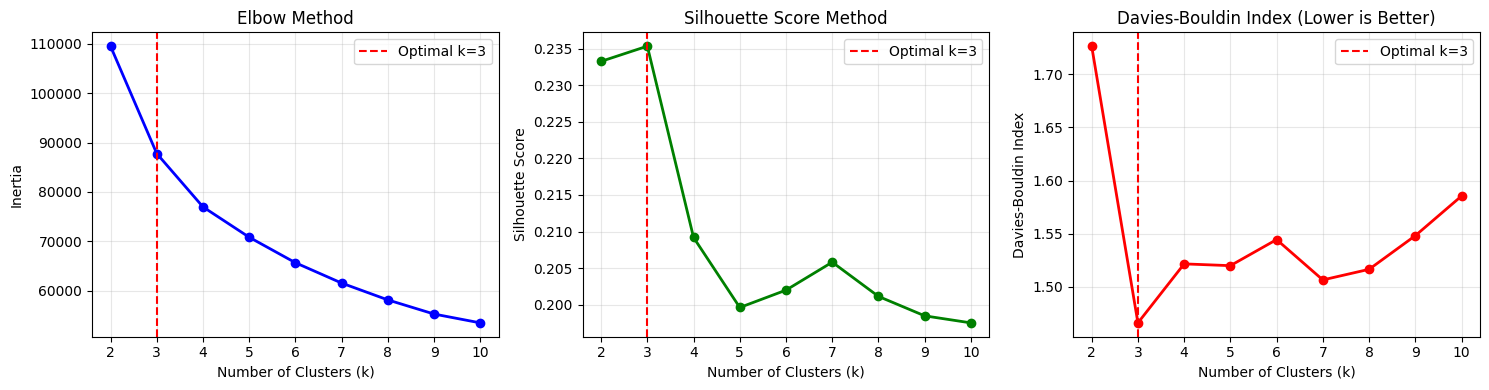

In [4]:
# ============================================================================
# 4. DETERMINE OPTIMAL NUMBER OF CLUSTERS
# ============================================================================

print("\n" + "="*70)
print("DETERMINING OPTIMAL NUMBER OF CLUSTERS")
print("="*70)

# Elbow Method and Silhouette Score
inertias = []
silhouette_scores = []
davies_bouldin_scores = []
k_range = range(2, 11)

print("\nEvaluating different numbers of clusters...")
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))
    davies_bouldin_scores.append(davies_bouldin_score(X_scaled, kmeans.labels_))
    print(f"k={k}: Inertia={kmeans.inertia_:.2f}, Silhouette={silhouette_scores[-1]:.4f}")

# Find optimal k using Silhouette Score (higher is better)
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"\nOptimal number of clusters (Silhouette): {optimal_k}")

# Visualize elbow method and silhouette scores
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Elbow plot
axes[0].plot(k_range, inertias, 'bo-', linewidth=2)
axes[0].axvline(x=optimal_k, color='red', linestyle='--', label=f'Optimal k={optimal_k}')
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method')
axes[0].grid(alpha=0.3)
axes[0].legend()

# Silhouette scores
axes[1].plot(k_range, silhouette_scores, 'go-', linewidth=2)
axes[1].axvline(x=optimal_k, color='red', linestyle='--', label=f'Optimal k={optimal_k}')
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score Method')
axes[1].grid(alpha=0.3)
axes[1].legend()

# Davies-Bouldin Index (lower is better)
axes[2].plot(k_range, davies_bouldin_scores, 'ro-', linewidth=2)
axes[2].axvline(x=optimal_k, color='red', linestyle='--', label=f'Optimal k={optimal_k}')
axes[2].set_xlabel('Number of Clusters (k)')
axes[2].set_ylabel('Davies-Bouldin Index')
axes[2].set_title('Davies-Bouldin Index (Lower is Better)')
axes[2].grid(alpha=0.3)
axes[2].legend()

plt.tight_layout()
plt.show()



In [5]:
# ============================================================================
# 5. TRAIN CLUSTERING MODELS
# ============================================================================

print("\n" + "="*70)
print("TRAINING CLUSTERING MODELS")
print("="*70)

# Model 1: K-Means Clustering
print(f"\n--- Model 1: K-Means Clustering (k={optimal_k}) ---")
kmeans_model = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_clusters = kmeans_model.fit_predict(X_scaled)
kmeans_silhouette = silhouette_score(X_scaled, kmeans_clusters)
print(f"✓ K-Means trained")
print(f"  Silhouette Score: {kmeans_silhouette:.4f}")
print(f"  Inertia: {kmeans_model.inertia_:.2f}")

# Model 2: Hierarchical Clustering (Ward linkage)
print(f"\n--- Model 2: Hierarchical Clustering (k={optimal_k}) ---")
hierarchical_model = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
hierarchical_clusters = hierarchical_model.fit_predict(X_scaled)
hierarchical_silhouette = silhouette_score(X_scaled, hierarchical_clusters)
print(f"✓ Hierarchical Clustering trained")
print(f"  Silhouette Score: {hierarchical_silhouette:.4f}")

# Model 3: DBSCAN
print(f"\n--- Model 3: DBSCAN ---")
# Find optimal eps using k-distance graph
distances = np.sort(np.linalg.norm(X_scaled[:1000], axis=1))  # Sample for speed
eps_value = distances[int(len(distances) * 0.9)]  # 90th percentile
dbscan_model = DBSCAN(eps=eps_value, min_samples=5)
dbscan_clusters = dbscan_model.fit_predict(X_scaled)
n_clusters_dbscan = len(set(dbscan_clusters)) - (1 if -1 in dbscan_clusters else 0)
n_noise_dbscan = list(dbscan_clusters).count(-1)
print(f"✓ DBSCAN trained")
print(f"  Number of clusters: {n_clusters_dbscan}")
print(f"  Number of noise points: {n_noise_dbscan}")

if n_clusters_dbscan > 1 and n_noise_dbscan < len(X_scaled) * 0.5:
    dbscan_silhouette = silhouette_score(X_scaled, dbscan_clusters)
    print(f"  Silhouette Score: {dbscan_silhouette:.4f}")
else:
    dbscan_silhouette = None
    print(f"  Silhouette Score: Not suitable for DBSCAN with these parameters")




TRAINING CLUSTERING MODELS

--- Model 1: K-Means Clustering (k=3) ---
✓ K-Means trained
  Silhouette Score: 0.2353
  Inertia: 87769.20

--- Model 2: Hierarchical Clustering (k=3) ---
✓ Hierarchical Clustering trained
  Silhouette Score: 0.2179

--- Model 3: DBSCAN ---
✓ DBSCAN trained
  Number of clusters: 1
  Number of noise points: 0
  Silhouette Score: Not suitable for DBSCAN with these parameters


In [6]:
# ============================================================================
# 6. CLUSTER EVALUATION
# ============================================================================

print("\n" + "="*70)
print("CLUSTER EVALUATION")
print("="*70)

evaluation_results = {
    'K-Means': {
        'Silhouette Score': kmeans_silhouette,
        'Number of Clusters': optimal_k,
        'Model': kmeans_model,
        'Labels': kmeans_clusters
    },
    'Hierarchical': {
        'Silhouette Score': hierarchical_silhouette,
        'Number of Clusters': optimal_k,
        'Model': hierarchical_model,
        'Labels': hierarchical_clusters
    }
}

if dbscan_silhouette is not None:
    evaluation_results['DBSCAN'] = {
        'Silhouette Score': dbscan_silhouette,
        'Number of Clusters': n_clusters_dbscan,
        'Model': dbscan_model,
        'Labels': dbscan_clusters
    }

# Compare models
print("\nModel Comparison:")
for model_name, metrics in evaluation_results.items():
    print(f"\n{model_name}:")
    print(f"  Silhouette Score: {metrics['Silhouette Score']:.4f}")
    print(f"  Number of Clusters: {metrics['Number of Clusters']}")

# Select best model
best_model_name = max(evaluation_results, key=lambda x: evaluation_results[x]['Silhouette Score'])
best_labels = evaluation_results[best_model_name]['Labels']

print(f"\n✓ Best model: {best_model_name}")




CLUSTER EVALUATION

Model Comparison:

K-Means:
  Silhouette Score: 0.2353
  Number of Clusters: 3

Hierarchical:
  Silhouette Score: 0.2179
  Number of Clusters: 3

✓ Best model: K-Means



VISUALIZING CLUSTERS
PCA explained variance ratio: [0.33363329 0.25099008]
Total variance explained: 0.5846


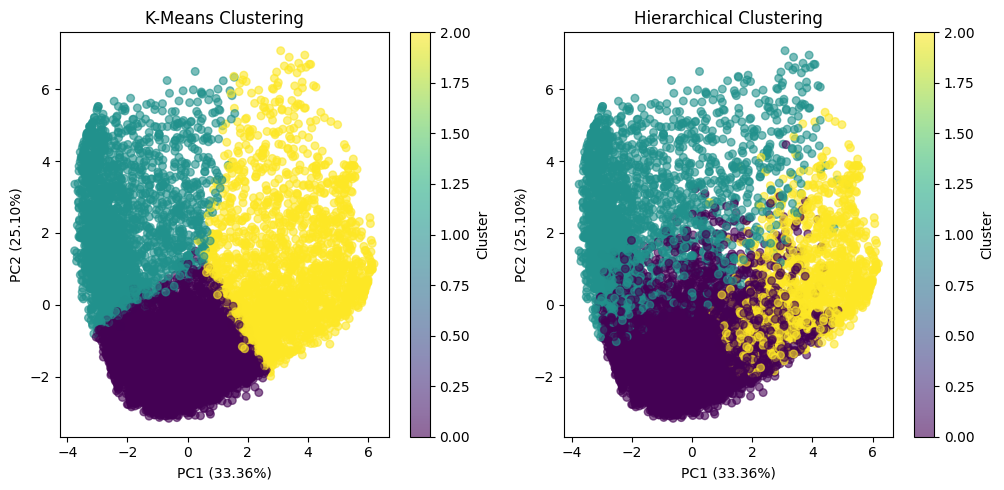

In [7]:
# ============================================================================
# 7. VISUALIZE CLUSTERS
# ============================================================================

print("\n" + "="*70)
print("VISUALIZING CLUSTERS")
print("="*70)

# Reduce dimensions for visualization using PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.4f}")

# Plot all models
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

models_to_plot = [
    ('K-Means', kmeans_clusters),
    ('Hierarchical', hierarchical_clusters),
    ('DBSCAN', dbscan_clusters) if dbscan_silhouette is not None else None
]

for idx, (model_info) in enumerate([m for m in models_to_plot if m is not None]):
    model_name, clusters = model_info
    
    scatter = axes[idx].scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', 
                                alpha=0.6, s=30)
    axes[idx].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
    axes[idx].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
    axes[idx].set_title(f'{model_name} Clustering')
    plt.colorbar(scatter, ax=axes[idx], label='Cluster')

# Remove extra subplots if DBSCAN not suitable
if dbscan_silhouette is None:
    fig.delaxes(axes[2])

plt.tight_layout()
plt.show()



In [8]:
# ============================================================================
# 8. CLUSTER CHARACTERISTICS AND INTERPRETATION
# ============================================================================

print("\n" + "="*70)
print("CLUSTER INTERPRETATION AND CHARACTERISTICS")
print("="*70)

# Add cluster labels to original dataframe
df['Cluster'] = best_labels

# Analyze each cluster
for cluster_id in sorted(np.unique(best_labels)):
    cluster_mask = best_labels == cluster_id
    cluster_data = X.iloc[cluster_mask]
    
    print(f"\n{'='*70}")
    print(f"CLUSTER {cluster_id} - {cluster_mask.sum()} customers ({cluster_mask.sum()/len(best_labels)*100:.1f}%)")
    print(f"{'='*70}")
    
    print(f"\nCluster characteristics (mean values):")
    cluster_means = cluster_data.mean()
    for feature, value in cluster_means.items():
        print(f"  {feature}: {value:.2f}")
    
    # Determine cluster profile
    print(f"\nCluster Profile Summary:")
    if cluster_data['BALANCE'].mean() > X['BALANCE'].median():
        print(f"  • HIGH BALANCE - High outstanding balances")
    else:
        print(f"  • LOW BALANCE - Low outstanding balances")
    
    if cluster_data['PURCHASES'].mean() > X['PURCHASES'].median():
        print(f"  • HIGH PURCHASES - High spending activity")
    else:
        print(f"  • LOW PURCHASES - Low spending activity")
    
    if cluster_data['CASH_ADVANCE'].mean() > X['CASH_ADVANCE'].median():
        print(f"  • HIGH CASH ADVANCE - Frequent cash withdrawals")
    else:
        print(f"  • LOW CASH ADVANCE - Minimal cash withdrawals")
    
    if cluster_data['PAYMENTS'].mean() > X['PAYMENTS'].median():
        print(f"  • GOOD PAYERS - High payment amounts")
    else:
        print(f"  • SLOW PAYERS - Low payment amounts")
    
    if cluster_data['PRC_FULL_PAYMENT'].mean() > X['PRC_FULL_PAYMENT'].median():
        print(f"  • FULL PAYMENT - Often pay in full")
    else:
        print(f"  • INSTALLMENTS - Prefer installments/partial payments")




CLUSTER INTERPRETATION AND CHARACTERISTICS

CLUSTER 0 - 4596 customers (51.4%)

Cluster characteristics (mean values):
  BALANCE: 564.49
  BALANCE_FREQUENCY: 0.90
  PURCHASES: 392.58
  ONEOFF_PURCHASES: 176.11
  INSTALLMENTS_PURCHASES: 205.63
  CASH_ADVANCE: 168.57
  PURCHASES_FREQUENCY: 0.46
  ONEOFF_PURCHASES_FREQUENCY: 0.10
  PURCHASES_INSTALLMENTS_FREQUENCY: 0.35
  CASH_ADVANCE_FREQUENCY: 0.04
  CASH_ADVANCE_TRX: 0.65
  PURCHASES_TRX: 7.41
  CREDIT_LIMIT: 3050.59
  PAYMENTS: 693.49
  MINIMUM_PAYMENTS: 357.00
  PRC_FULL_PAYMENT: 0.10
  TENURE: 12.00

Cluster Profile Summary:
  • LOW BALANCE - Low outstanding balances
  • HIGH PURCHASES - High spending activity
  • HIGH CASH ADVANCE - Frequent cash withdrawals
  • SLOW PAYERS - Low payment amounts
  • FULL PAYMENT - Often pay in full

CLUSTER 1 - 2315 customers (25.9%)

Cluster characteristics (mean values):
  BALANCE: 2742.88
  BALANCE_FREQUENCY: 0.96
  PURCHASES: 228.98
  ONEOFF_PURCHASES: 139.46
  INSTALLMENTS_PURCHASES: 77.47
  


CLUSTER PROFILE HEATMAP


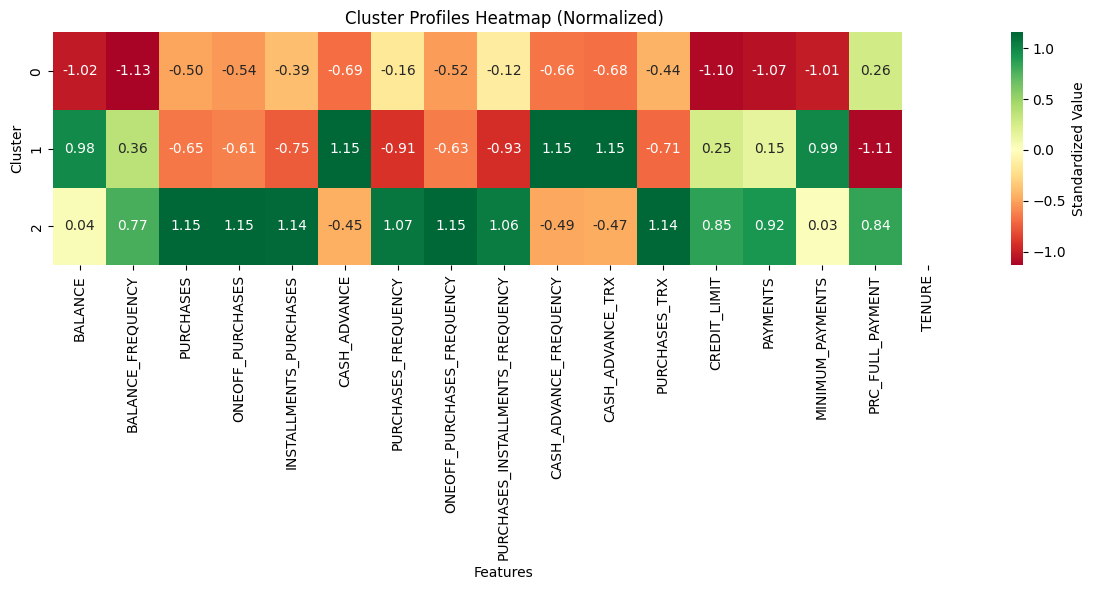

In [9]:
# ============================================================================
# 9. HEATMAP OF CLUSTER PROFILES
# ============================================================================

print("\n" + "="*70)
print("CLUSTER PROFILE HEATMAP")
print("="*70)

# Normalize cluster means for better visualization
cluster_profiles = []
for cluster_id in sorted(np.unique(best_labels)):
    cluster_mask = best_labels == cluster_id
    cluster_profiles.append(X.iloc[cluster_mask].mean())

cluster_profiles_df = pd.DataFrame(cluster_profiles)
cluster_profiles_normalized = (cluster_profiles_df - cluster_profiles_df.mean()) / cluster_profiles_df.std()

plt.figure(figsize=(12, 6))
sns.heatmap(cluster_profiles_normalized, annot=True, fmt='.2f', cmap='RdYlGn', 
            center=0, cbar_kws={'label': 'Standardized Value'})
plt.title('Cluster Profiles Heatmap (Normalized)')
plt.ylabel('Cluster')
plt.xlabel('Features')
plt.tight_layout()
plt.show()



In [10]:
# ============================================================================
# 10. SAVE RESULTS
# ============================================================================

print("\n" + "="*70)
print("SAVING RESULTS")
print("="*70)

# Create results dataframe
results_df = pd.DataFrame({
    'CUST_ID': customer_ids,
    'Cluster': best_labels
})

# Save to CSV
results_df.to_csv('data/submissions/clustering_results.csv', index=False)
print(f"✓ Clustering results saved!")
print(f"\nResults preview:")
print(results_df.head(10))

# Also save cluster profiles
cluster_profiles_df.to_csv('data/submissions/cluster_profiles.csv')
print(f"✓ Cluster profiles saved!")




SAVING RESULTS
✓ Clustering results saved!

Results preview:
  CUST_ID  Cluster
0  C10001        0
1  C10002        1
2  C10003        2
3  C10004        0
4  C10005        0
5  C10006        0
6  C10007        2
7  C10008        0
8  C10009        0
9  C10010        0
✓ Cluster profiles saved!



SILHOUETTE ANALYSIS


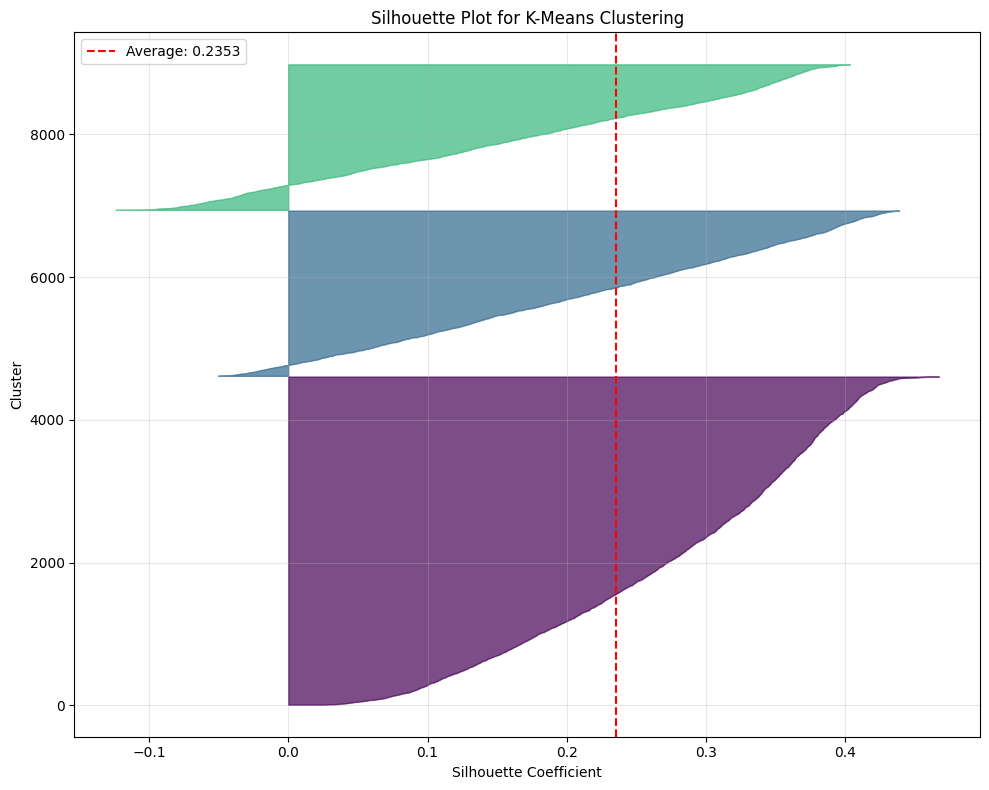

In [11]:
# ============================================================================
# 11. SILHOUETTE PLOT
# ============================================================================

print("\n" + "="*70)
print("SILHOUETTE ANALYSIS")
print("="*70)

fig, ax = plt.subplots(figsize=(10, 8))

silhouette_vals = silhouette_samples(X_scaled, best_labels)
y_lower = 10

for i in range(optimal_k):
    cluster_silhouette_vals = silhouette_vals[best_labels == i]
    cluster_silhouette_vals.sort()
    
    size_cluster_i = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = plt.cm.viridis(float(i) / optimal_k)
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals,
                     facecolor=color, edgecolor=color, alpha=0.7)
    
    y_lower = y_upper + 10

ax.set_xlabel('Silhouette Coefficient')
ax.set_ylabel('Cluster')
ax.set_title(f'Silhouette Plot for {best_model_name} Clustering')
ax.axvline(x=silhouette_vals.mean(), color='red', linestyle='--', label=f'Average: {silhouette_vals.mean():.4f}')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()



In [12]:
# ============================================================================
# 12. CONCLUSIONS AND INSIGHTS
# ============================================================================

print("\n" + "="*70)
print("CONCLUSIONS AND INSIGHTS")
print("="*70)

print(f"""
1. BEST CLUSTERING MODEL: {best_model_name}
   - Silhouette Score: {evaluation_results[best_model_name]['Silhouette Score']:.4f}
   - Number of Clusters: {optimal_k}
   - This model best separates distinct customer segments.

2. CUSTOMER SEGMENTATION:
   - Successfully identified {optimal_k} distinct customer groups.
   - Each cluster represents a unique spending and payment behavior pattern.
   - Customers can be targeted with personalized strategies based on cluster.

3. CLUSTER-BASED INSIGHTS:
   - Cluster analysis reveals diverse credit card usage patterns.
   - Some clusters show high spending with good payment discipline.
   - Other clusters show low activity or risky payment behaviors.
   - This enables risk assessment and targeted marketing.

4. BUSINESS RECOMMENDATIONS:
   - Use cluster assignments for customer segmentation and targeting.
   - Design cluster-specific loyalty programs and incentives.
   - Monitor cluster transitions to detect behavioral changes.
   - Use cluster profiles for credit limit and promotion decisions.
   - Consider re-clustering periodically to adapt to changing patterns.

5. NEXT STEPS:
   - Validate clusters with domain experts.
   - Implement recommendations with marketing and credit teams.
   - Monitor cluster stability over time.
   - Explore cluster-specific risk models.
""")


CONCLUSIONS AND INSIGHTS

1. BEST CLUSTERING MODEL: K-Means
   - Silhouette Score: 0.2353
   - Number of Clusters: 3
   - This model best separates distinct customer segments.

2. CUSTOMER SEGMENTATION:
   - Successfully identified 3 distinct customer groups.
   - Each cluster represents a unique spending and payment behavior pattern.
   - Customers can be targeted with personalized strategies based on cluster.

3. CLUSTER-BASED INSIGHTS:
   - Cluster analysis reveals diverse credit card usage patterns.
   - Some clusters show high spending with good payment discipline.
   - Other clusters show low activity or risky payment behaviors.
   - This enables risk assessment and targeted marketing.

4. BUSINESS RECOMMENDATIONS:
   - Use cluster assignments for customer segmentation and targeting.
   - Design cluster-specific loyalty programs and incentives.
   - Monitor cluster transitions to detect behavioral changes.
   - Use cluster profiles for credit limit and promotion decisions.
   - 